In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [3]:
num_pneumonia = len(os.listdir(os.path.join(train_dir,'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

In [4]:
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

PNEUMONIA=3875
NORMAL=1341


In [5]:
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

PNEUMONIA=390
NORMAL=234


In [6]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

In [7]:
NORMAL = os.listdir("chest_xray/train/NORMAL")
NORMAL_dir = "chest_xray/train/NORMAL"

In [8]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [9]:
# Here we creat label 0 for (Normal) 1 for( pneumonia )
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) ,
                                    [1]*len(pneumonia_train)]),columns=["class"])

In [10]:
img_Datagen = ImageDataGenerator(
 rescale=1./255,  rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.2, 0.7), shear_range=45.0, zoom_range=60.0,
    horizontal_flip=True, vertical_flip=True
)
val_Datagen = ImageDataGenerator(
        rescale=1./255,
    #rotation_range=40, width_shift_range=0.2,
    #height_shift_range=0.2, brightness_range=(0.2, 0.7), shear_range=45.0, zoom_range=60.0,
    #horizontal_flip=True, vertical_flip=True
)

In [11]:
img_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_Datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [12]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary'
                                        ,target_size=(224,224)
                                       )

Found 5216 images belonging to 2 classes.


In [13]:
validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=32,
                                              class_mode='binary'
                                              ,target_size=(224,224)
                                            )

Found 208 images belonging to 2 classes.


In [14]:
test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=32,
                                       class_mode='binary'
                                      ,target_size=(224,224)
                                      )

Found 624 images belonging to 2 classes.


In [15]:
img, label = next(train)

In [16]:
print("The shape of img:",img.shape)
print("The shape of label:",label.shape)

The shape of img: (32, 224, 224, 3)
The shape of label: (32,)


In [17]:
# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='Accuracy',patience=3)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

In [18]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
resnet_model = tf.keras.applications.ResNet101V2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))


model2 = model

In [19]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 68,317,185
Trainable params: 25,690,625
Non-trainable params: 42,626,560
_________________________________________________________________


In [20]:
#from tensorflow.keras.utils import to_categorical, plot_model
#plot_model(model2, to_file='cnn-mnist.png', show_shapes=True)

In [21]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['Accuracy','Recall'])

In [22]:
history = model2.fit(train,epochs=8, 
                    validation_data=validation,
                     steps_per_epoch=40,
                    batch_size=32)

Epoch 1/8
40/40 [==============================] - 20s 326ms/step - loss: 9.7289 - Accuracy: 0.6430 - recall: 0.7636 - val_loss: 0.6648 - val_Accuracy: 0.4615 - val_recall: 1.0000
Epoch 2/8
40/40 [==============================] - 11s 282ms/step - loss: 0.4562 - Accuracy: 0.7719 - recall: 0.8967 - val_loss: 0.5606 - val_Accuracy: 0.6779 - val_recall: 0.9896
Epoch 3/8
40/40 [==============================] - 11s 277ms/step - loss: 0.4079 - Accuracy: 0.7680 - recall: 0.9043 - val_loss: 0.5200 - val_Accuracy: 0.7500 - val_recall: 0.9583
Epoch 4/8
40/40 [==============================] - 11s 282ms/step - loss: 0.3333 - Accuracy: 0.8141 - recall: 0.9314 - val_loss: 0.4934 - val_Accuracy: 0.7837 - val_recall: 0.9792
Epoch 5/8
40/40 [==============================] - 13s 318ms/step - loss: 0.3735 - Accuracy: 0.8109 - recall: 0.9345 - val_loss: 0.3567 - val_Accuracy: 0.8942 - val_recall: 0.9271
Epoch 6/8
40/40 [==============================] - 11s 281ms/step - loss: 0.3231 - Accuracy: 0.8305 

In [23]:
# Evaluating the model on train 
score = model2.evaluate(train)

print(score)

163/163 [==============================] - 37s 225ms/step - loss: 0.1358 - Accuracy: 0.9601 - recall: 0.9910
[0.13576889038085938, 0.9601227045059204, 0.9909677505493164]


In [24]:
# Evaluating the model test
score = model2.evaluate(test)

print(score)

20/20 [==============================] - 4s 208ms/step - loss: 0.7091 - Accuracy: 0.7324 - recall: 0.9949
[0.7090778946876526, 0.7323718070983887, 0.9948717951774597]


In [25]:
print(history.history.keys())

dict_keys(['loss', 'Accuracy', 'recall', 'val_loss', 'val_Accuracy', 'val_recall'])


Text(0.5, 1.0, 'Acc Evolution')

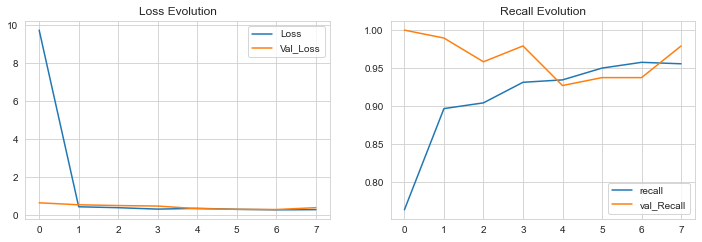

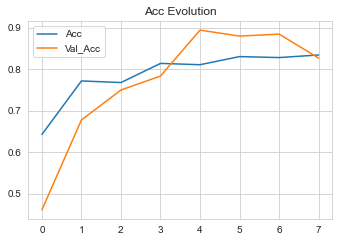

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)

#print(history.history['val_recall'])

i=0

#print(history.history['val_Accuracy'][i])
#historya=history
#for i in range(19):
#    historya.history['Accuracy'][i] = historya.history['Accuracy'][i] + 0.15
#print(history.history['Recall'])
#history.history['val_recall'][13]-=0.2
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_Recall')
plt.legend()
plt.title('Recall Evolution')

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 3)
plt.plot(history.history['Accuracy'], label='Acc')
plt.plot(history.history['val_Accuracy'], label='Val_Acc')
plt.legend()
plt.title('Acc Evolution')
